<a href="https://colab.research.google.com/github/syaifulafrizal/DeepLearning/blob/main/Assignment_2_(Syaiful_Afrizal).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [2]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

dataset1 = '/content/drive/MyDrive/old_fruit_dataset'
dataset2 = '/content/drive/MyDrive/fruit_dataset'

#########IMPORTANT##########
#1 is used for model-centric
#2 is used for data-centric

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load the Data

# Set train and valid directory paths

# dataset = '/content/drive/My Drive/01. TEACHING/MACHINE_VISION/code/fruit_dataset'


train_directory1 = os.path.join(dataset1, 'train')
test_directory1 = os.path.join(dataset1, 'validation')

train_directory2 = os.path.join(dataset2, 'train')
test_directory2 = os.path.join(dataset2, 'validation')

# Batch size
batchSize1 = 64
batchSize2 = 32
# Number of classes

num_classes1 = len(os.listdir(train_directory1))
num_classes2 = len(os.listdir(train_directory1))
print(num_classes1)
print(num_classes2)

# Load Data from folders
data1 = {
    'train': datasets.ImageFolder(root=train_directory1, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory1, transform=image_transforms['test'])
}
data2 = {
    'train': datasets.ImageFolder(root=train_directory2, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory2, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

4
4


In [5]:
data1['train']
data2['train']

Dataset ImageFolder
    Number of datapoints: 499
    Root location: /content/drive/MyDrive/fruit_dataset/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size1 = len(data1['train'])
train_data_size2 = len(data2['train'])
# valid_data_size = len(data['valid'])
test_data_size1 = len(data1['test'])
test_data_size2 = len(data2['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader1 = DataLoader(data1['train'], batch_size=batchSize1, shuffle=True)
train_data_loader2 = DataLoader(data2['train'], batch_size=batchSize2, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
test_data_loader1 = DataLoader(data1['test'], batch_size=batchSize1, shuffle=True)
test_data_loader2 = DataLoader(data2['test'], batch_size=batchSize2, shuffle=True)

In [7]:
train_data_size1, test_data_size1, train_data_size2, test_data_size2

(521, 323, 499, 323)

In [8]:
input_size = (3,32,32)

In [9]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader1 = DataLoader(dataset=data1['train'], # use custom created train Dataset
                                     batch_size=4, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?
trainloader2 = DataLoader(dataset=data2['train'], 
                                     batch_size=4, 
                                     num_workers=0, 
                                     shuffle=True) 

testloader1 = DataLoader(dataset=data1['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data
testloader2 = DataLoader(dataset=data2['test'],
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) 

train_data_size1 = len(trainloader1.dataset)
train_data_size2 = len(trainloader2.dataset)
test_data_size1 = len(testloader1.dataset)
test_data_size2 = len(testloader2.dataset)

print(train_data_size1)
print(test_data_size1)
print(train_data_size2)
print(test_data_size2)

521
323
499
323


In [10]:
#MODEL FOR MODEL-CENTRIC
model_ft_1 = models.vgg16(pretrained=True)
num_ftrs_1 = model_ft_1.classifier[6].in_features #must use the name same as model_ft -> can try to display
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_1.classifier[6] = nn.Linear(num_ftrs_1, 4)

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(model_ft_1.parameters(), lr=0.0001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft_1.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
model_ft_1.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
#MODEL FOR DATA-CENTRIC 
model_ft_2 = models.alexnet(pretrained=True)
num_ftrs_2 = model_ft_2.classifier[6].in_features #must use the name same as model_ft -> can try to display
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_2.classifier[6] = nn.Linear(num_ftrs_2, 4)

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(model_ft_2.parameters(), lr=0.00001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft_2.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
import time # to calculate training time for MODEL-CENTRIC

def train_and_validate1(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader1):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader1):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size1
        avg_train_acc = train_acc/train_data_size1

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size1 
        avg_test_acc = valid_acc/test_data_size1

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [14]:
# 4. Train the MODEL-CENTRIC model for 10 epochs
 
num_epochs = 10
trained_model1, history1 = train_and_validate1(model_ft_1, criterion, optimizer1, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.5806, Accuracy: 79.8464%, 
		Validation : Loss : 0.7655, Accuracy: 84.2105%, Time: 565.2624s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.3753, Accuracy: 89.0595%, 
		Validation : Loss : 0.6242, Accuracy: 84.5201%, Time: 18.4529s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.2737, Accuracy: 91.9386%, 
		Validation : Loss : 0.5963, Accuracy: 82.0433%, Time: 18.5992s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.2362, Accuracy: 92.1305%, 
		Validation : Loss : 0.5309, Accuracy: 84.5201%, Time: 19.4900s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.2385, Accuracy: 91.5547%, 
		Validation : Loss : 0.5000, Accuracy: 82.3529%, Time: 19.4791s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.2103, Accuracy: 92.8983%, 
		Validation : Loss : 0.3611, Accuracy: 86.9969%, Time: 19.8091s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.1892, Accuracy: 93.0902%, 
		Validation : Loss : 0.3848, Accuracy: 87.6161%, Time: 19.7765s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.1641, Accur

In [15]:
import time # to calculate training time for DATA CENTRIC

def train_and_validate2(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader2):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader2):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size2
        avg_train_acc = train_acc/train_data_size2

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size2 
        avg_test_acc = valid_acc/test_data_size2

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_data_'+str(epoch)+'.pt')
            
    return model, history

In [16]:
#Train the DATA-CENTRIC model for 10 epochs
 
num_epochs = 10
trained_model2, history2 = train_and_validate2(model_ft_2, criterion, optimizer2, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.8327, Accuracy: 68.3367%, 
		Validation : Loss : 0.8675, Accuracy: 65.0155%, Time: 690.6021s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.3515, Accuracy: 89.9800%, 
		Validation : Loss : 0.5063, Accuracy: 84.8297%, Time: 6.9304s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.2202, Accuracy: 94.5892%, 
		Validation : Loss : 0.4078, Accuracy: 87.9257%, Time: 6.9331s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.1766, Accuracy: 97.3948%, 
		Validation : Loss : 0.3336, Accuracy: 88.5449%, Time: 6.8494s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.1504, Accuracy: 97.3948%, 
		Validation : Loss : 0.2917, Accuracy: 90.0929%, Time: 6.8786s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.1472, Accuracy: 96.9940%, 
		Validation : Loss : 0.2499, Accuracy: 92.5697%, Time: 6.8510s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.1292, Accuracy: 97.9960%, 
		Validation : Loss : 0.2330, Accuracy: 92.5697%, Time: 6.8810s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.1075, Accuracy: 9

In [17]:
#Train the COMBINATION OF BOTH models for 10 epochs
 
num_epochs = 10
trained_model3, history = train_and_validate2(model_ft_1, criterion, optimizer1, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.0795, Accuracy: 97.3948%, 
		Validation : Loss : 0.1271, Accuracy: 96.2848%, Time: 17.9760s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.0479, Accuracy: 98.5972%, 
		Validation : Loss : 0.0953, Accuracy: 96.5944%, Time: 18.2364s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.0504, Accuracy: 98.1964%, 
		Validation : Loss : 0.0872, Accuracy: 96.9040%, Time: 18.6808s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.0306, Accuracy: 98.9980%, 
		Validation : Loss : 0.0982, Accuracy: 96.5944%, Time: 18.4770s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.0246, Accuracy: 99.1984%, 
		Validation : Loss : 0.0992, Accuracy: 97.5232%, Time: 18.5101s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.0235, Accuracy: 98.7976%, 
		Validation : Loss : 0.0691, Accuracy: 98.1424%, Time: 18.5423s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.0188, Accuracy: 99.3988%, 
		Validation : Loss : 0.0657, Accuracy: 97.8328%, Time: 18.4958s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.0305, Accura

In [18]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time


# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [19]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [20]:
categories=['durian', 'pumpkin', 'tomato', 'watermelon']

In [21]:
print(trained_model3)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

<IPython.core.display.Javascript object>

pumpkin 0.45636820793151855


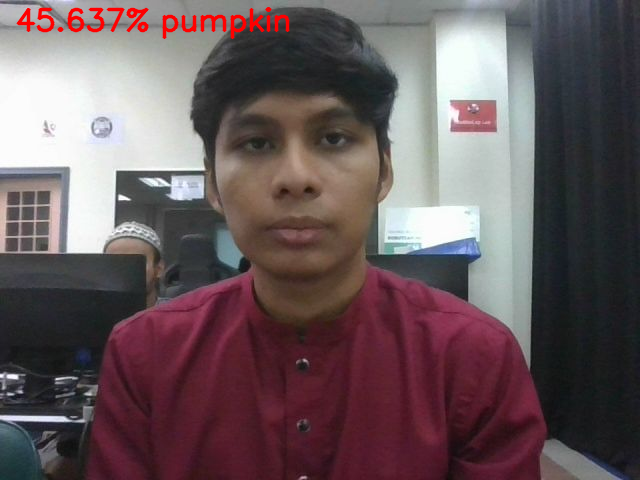

tomato 0.973275363445282


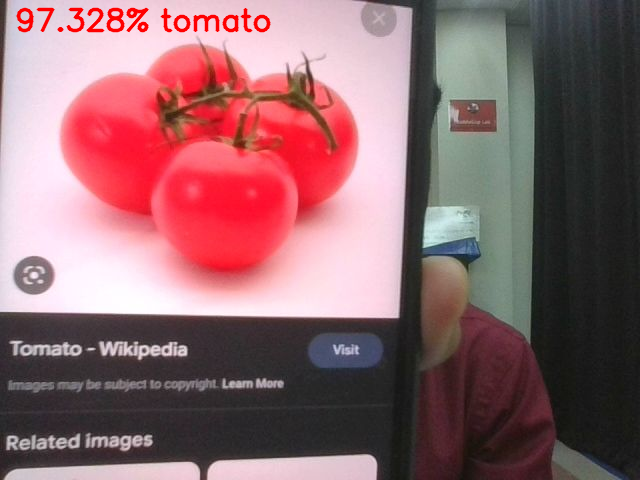

tomato 0.8729912042617798


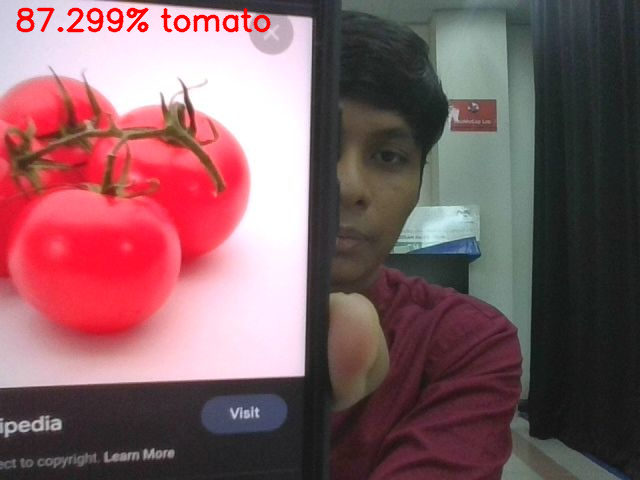

pumpkin 0.4486055374145508


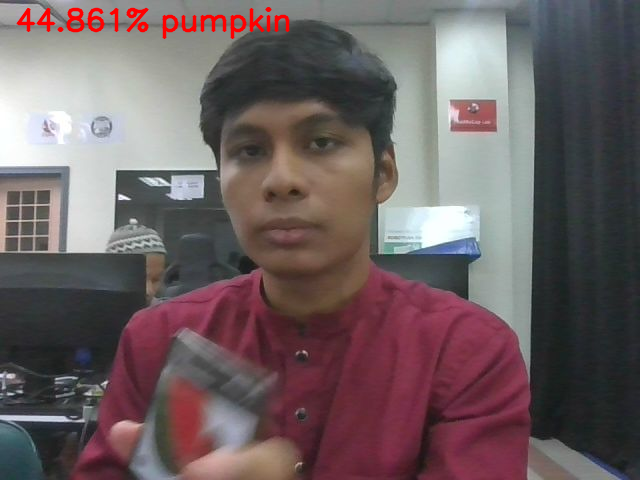

watermelon 0.46118274331092834


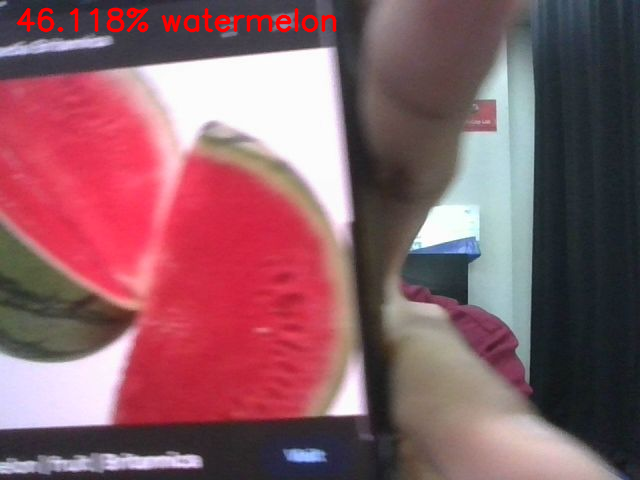

watermelon 0.994257926940918


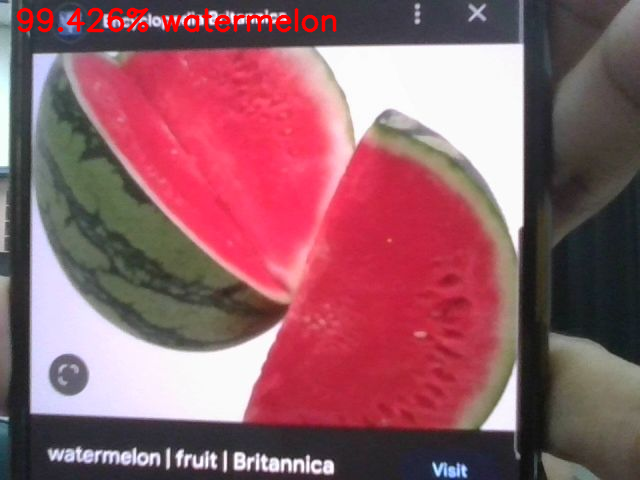

watermelon 0.3775564134120941


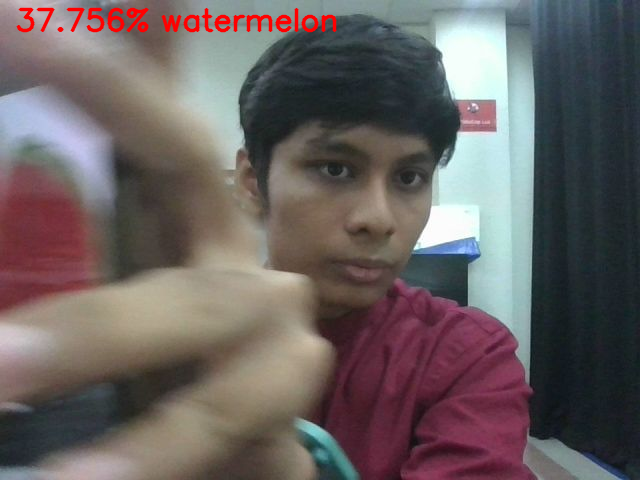

In [29]:
transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    ])
from google.colab.patches import cv2_imshow

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    #     rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Apply transforms to the input image.
    input_tensor = transform(frame)
    # Add the batch dimension.
    input_batch = input_tensor.unsqueeze(0)
    input_batch = input_batch.to(device)
    
    with torch.no_grad():
        start_time = time.time()
        output = trained_model3(input_batch)
        end_time = time.time()
    # Get the softmax probabilities.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    # Check the top 5 categories that are predicted.
    top5_prob, top5_catid = torch.topk(probabilities, 4)
    
    cv2.putText(frame, f"{top5_prob[0].item()*100:.3f}%", (15, (1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, f"{categories[top5_catid[0]]}", (160, (1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(categories[top5_catid[0]], top5_prob[0].item())
    cv2_imshow(frame)